Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

1875/1875 [==============================] - 391s 208ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0406 - val_accuracy: 0.9931 - lr: 1.0000e-07
Epoch 2/20
1875/1875 [==============================] - 383s 204ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0403 - val_accuracy: 0.9931 - lr: 1.0000e-07
Epoch 3/20
1875/1875 [==============================] - 382s 204ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0406 - val_accuracy: 0.9930 - lr: 1.0000e-07
Epoch 4/20
1875/1875 [==============================] - 381s 203ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0410 - val_accuracy: 0.9930 - lr: 1.0000e-07
Epoch 5/20
1875/1875 [==============================] - 383s 204ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0401 - val_accuracy: 0.9933 - lr: 1.0000e-07
Epoch 6/20
1875/1875 [==============================] - 381s 203ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0523 - val_accuracy: 0.9911 - lr: 5.0000e-06
Epoch 7/20
1875/1875 

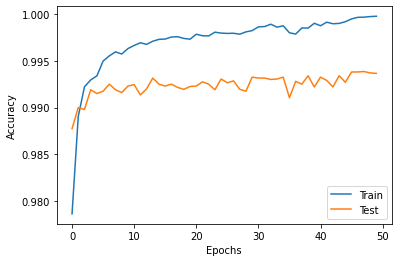

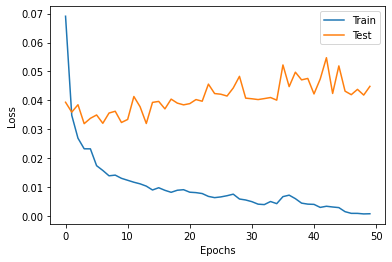

<AxesSubplot:>

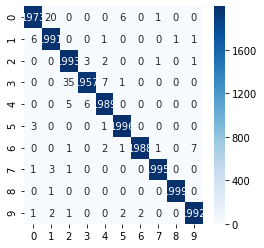

In [1]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Numerals/FARSI/train/'
validation_data_dir = './Data/Offline/Numerals/FARSI/test/'
nb_train_samples = 60000
nb_validation_samples = 20000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9936884718897228
recall_score   :  0.99365
f1_score       :  0.9936498457182603
accuracy_score :  0.99365

Best accuracy  :  0.9938499927520752


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

1875/1875 [==============================] - 390s 208ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0450 - val_accuracy: 0.9924 - lr: 1.0000e-07
Epoch 2/20
1875/1875 [==============================] - 385s 205ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0437 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 3/20
1875/1875 [==============================] - 385s 205ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0439 - val_accuracy: 0.9924 - lr: 1.0000e-07
Epoch 4/20
1875/1875 [==============================] - 385s 205ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0448 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 5/20
1875/1875 [==============================] - 384s 205ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0436 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 6/20
1875/1875 [==============================] - 384s 205ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0488 - val_accuracy: 0.9921 - lr: 5.0000e-06
Epoch 7/20
1875/1875 

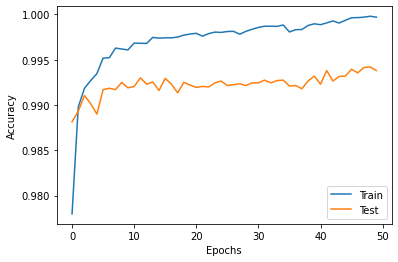

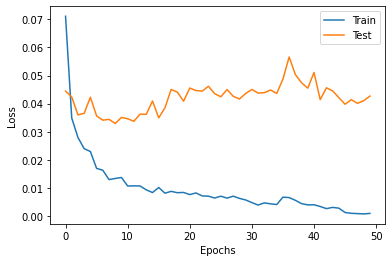

<AxesSubplot:>

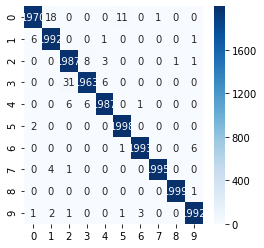

In [3]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Numerals/FARSI/train/'
validation_data_dir = './Data/Offline/Numerals/FARSI/test/'
nb_train_samples = 60000
nb_validation_samples = 20000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [4]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.993824258252579
recall_score   :  0.9938
f1_score       :  0.9937994097836066
accuracy_score :  0.9938

Best accuracy  :  0.9941999912261963


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

1875/1875 [==============================] - 391s 208ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0436 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 2/20
1875/1875 [==============================] - 383s 204ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0434 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 3/20
1875/1875 [==============================] - 383s 204ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0437 - val_accuracy: 0.9928 - lr: 1.0000e-07
Epoch 4/20
1875/1875 [==============================] - 382s 204ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0418 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 5/20
1875/1875 [==============================] - 383s 205ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0426 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 6/20
1875/1875 [==============================] - 384s 205ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0475 - val_accuracy: 0.9923 - lr: 5.0000e-06
Epoch 7/20
1875/1875 

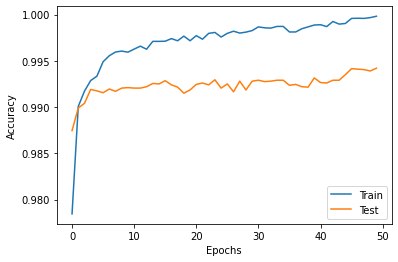

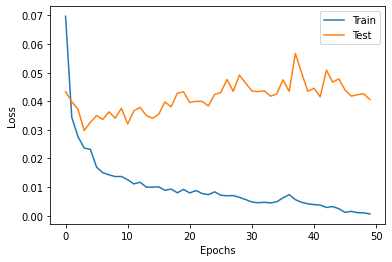

<AxesSubplot:>

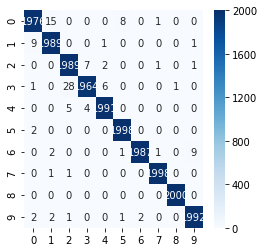

In [5]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Numerals/FARSI/train/'
validation_data_dir = './Data/Offline/Numerals/FARSI/test/'
nb_train_samples = 60000
nb_validation_samples = 20000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [6]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9942171139201245
recall_score   :  0.9942
f1_score       :  0.9941987859750785
accuracy_score :  0.9942

Best accuracy  :  0.9941999912261963


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

1875/1875 [==============================] - 390s 208ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0468 - val_accuracy: 0.9928 - lr: 1.0000e-07
Epoch 2/20
1875/1875 [==============================] - 379s 202ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0471 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 3/20
1875/1875 [==============================] - 381s 203ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0470 - val_accuracy: 0.9926 - lr: 1.0000e-07
Epoch 4/20
1875/1875 [==============================] - 381s 203ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0482 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 5/20
1875/1875 [==============================] - 381s 203ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.0463 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 6/20
1875/1875 [==============================] - 380s 203ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0477 - val_accuracy: 0.9921 - lr: 5.0000e-06
Epoch 7/20
1875/1875 

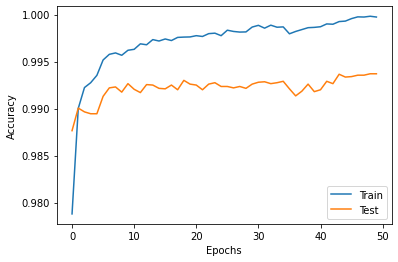

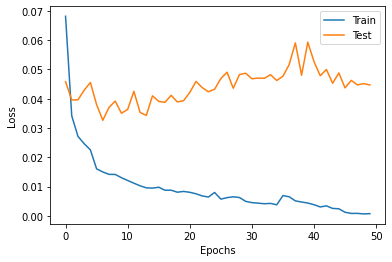

<AxesSubplot:>

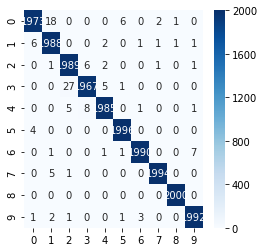

In [7]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Numerals/FARSI/train/'
validation_data_dir = './Data/Offline/Numerals/FARSI/test/'
nb_train_samples = 60000
nb_validation_samples = 20000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [8]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9937178697897592
recall_score   :  0.9937000000000001
f1_score       :  0.9936999302000118
accuracy_score :  0.9937

Best accuracy  :  0.9937000274658203


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

1875/1875 [==============================] - 390s 208ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0405 - val_accuracy: 0.9928 - lr: 1.0000e-07
Epoch 2/20
1875/1875 [==============================] - 383s 204ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0405 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 3/20
1875/1875 [==============================] - 382s 204ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0412 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 4/20
1875/1875 [==============================] - 382s 204ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0413 - val_accuracy: 0.9929 - lr: 1.0000e-07
Epoch 5/20
1875/1875 [==============================] - 382s 204ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0420 - val_accuracy: 0.9927 - lr: 1.0000e-07
Epoch 6/20
1875/1875 [==============================] - 382s 204ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0541 - val_accuracy: 0.9916 - lr: 5.0000e-06
Epoch 7/20
1875/1875 

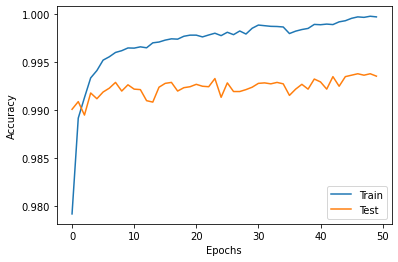

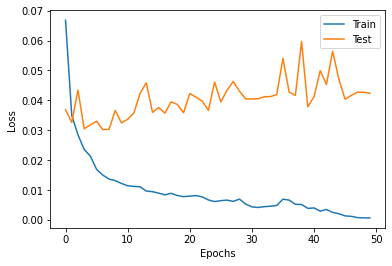

<AxesSubplot:>

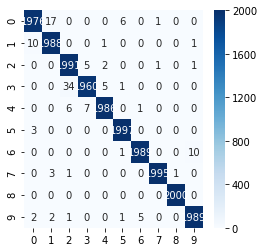

In [2]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Numerals/FARSI/train/'
validation_data_dir = './Data/Offline/Numerals/FARSI/test/'
nb_train_samples = 60000
nb_validation_samples = 20000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [3]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9935772157500484
recall_score   :  0.9935500000000002
f1_score       :  0.9935502993207797
accuracy_score :  0.99355

Best accuracy  :  0.9937999844551086
